## Importing Modules

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.regularizers import l2, l1

from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import matthews_corrcoef

import xgboost as xgb
import lightgbm as lgb

%matplotlib inline

2024-08-17 11:38:05.089171: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-17 11:38:05.089284: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-17 11:38:05.227140: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Load and explore data

In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s4e8/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e8/test.csv')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3116945 entries, 0 to 3116944
Data columns (total 22 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   class                 object 
 2   cap-diameter          float64
 3   cap-shape             object 
 4   cap-surface           object 
 5   cap-color             object 
 6   does-bruise-or-bleed  object 
 7   gill-attachment       object 
 8   gill-spacing          object 
 9   gill-color            object 
 10  stem-height           float64
 11  stem-width            float64
 12  stem-root             object 
 13  stem-surface          object 
 14  stem-color            object 
 15  veil-type             object 
 16  veil-color            object 
 17  has-ring              object 
 18  ring-type             object 
 19  spore-print-color     object 
 20  habitat               object 
 21  season                object 
dtypes: float64(3), int64(1), object(18)
memory

In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2077964 entries, 0 to 2077963
Data columns (total 21 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   cap-diameter          float64
 2   cap-shape             object 
 3   cap-surface           object 
 4   cap-color             object 
 5   does-bruise-or-bleed  object 
 6   gill-attachment       object 
 7   gill-spacing          object 
 8   gill-color            object 
 9   stem-height           float64
 10  stem-width            float64
 11  stem-root             object 
 12  stem-surface          object 
 13  stem-color            object 
 14  veil-type             object 
 15  veil-color            object 
 16  has-ring              object 
 17  ring-type             object 
 18  spore-print-color     object 
 19  habitat               object 
 20  season                object 
dtypes: float64(3), int64(1), object(17)
memory usage: 332.9+ MB


## Feature engineering

In [5]:
train = train.drop(['id'], axis=1)
test = test.drop(['id'], axis=1)

In [6]:
num_col = train.select_dtypes(include='float64').columns
cat_col = train.select_dtypes(include='object').columns
target = 'class'

In [7]:
col = 'cap-diameter'
train[col] = train[col].fillna(float(train[col].median()))
scaler1 = MinMaxScaler()
train[col] = scaler1.fit_transform(train[[col]])

col = 'cap-diameter'
test[col] = test[col].fillna(float(test[col].median()))
scaler1 = MinMaxScaler()
train[col] = scaler1.fit_transform(train[[col]])

col = 'stem-height'
test[col] = test[col].fillna(float(test[col].median()))
scaler1 = MinMaxScaler()
train[col] = scaler1.fit_transform(train[[col]])

In [8]:
print(f"Total percentage of missing values in Train Data")

missing_count = train.isna().sum()
total_count = train.shape[0]
missing_percentage = (missing_count / total_count) * 100
high_missing_percentage = missing_percentage[missing_percentage > 50]
print(high_missing_percentage)

print(f"Total percentage of missing values in Test Data")

missing_count = test.isna().sum()
total_count = test.shape[0]
missing_percentage = (missing_count / total_count) * 100
high_missing_percentage = missing_percentage[missing_percentage > 50]
print(high_missing_percentage)

train = train.drop(['veil-type', 'spore-print-color', 'stem-root', 'veil-color'], axis=1)
test = test.drop(['veil-type', 'spore-print-color', 'stem-root', 'veil-color'], axis=1)

num_col = train.select_dtypes(include='float64').columns
cat_col = train.select_dtypes(include='object').columns
target = 'class'

Total percentage of missing values in Train Data
stem-root            88.452732
stem-surface         63.551362
veil-type            94.884350
veil-color           87.936970
spore-print-color    91.425482
dtype: float64
Total percentage of missing values in Test Data
stem-root            88.452543
stem-surface         63.595327
veil-type            94.878689
veil-color           87.880445
spore-print-color    91.417224
dtype: float64


In [9]:
for column in cat_col:
    if train[column].isnull().any():      
        mode_value = 'miss'
        train[column].fillna(mode_value, inplace=True)
        mode_value1 = 'miss'
        test[column].fillna(mode_value1, inplace=True) 

In [10]:
remaining_nans = train.isnull().sum()
print("Remaining NaN values after imputation:")
print(remaining_nans)

Remaining NaN values after imputation:
class                   0
cap-diameter            0
cap-shape               0
cap-surface             0
cap-color               0
does-bruise-or-bleed    0
gill-attachment         0
gill-spacing            0
gill-color              0
stem-height             0
stem-width              0
stem-surface            0
stem-color              0
has-ring                0
ring-type               0
habitat                 0
season                  0
dtype: int64


In [11]:
cat_col = list(cat_col)
cat_col.remove(target)

encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

train[cat_col] = encoder.fit_transform(train[cat_col].astype(str))
test[cat_col] = encoder.transform(test[cat_col].astype(str))

In [12]:
le = LabelEncoder()
train[target] = le.fit_transform(train[target])

In [13]:
train.head()

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-surface,stem-color,has-ring,ring-type,habitat,season
0,0,0.108755,53.0,73.0,73.0,8.0,44.0,28.0,60.0,0.050834,15.39,47.0,56.0,5.0,18.0,25.0,0.0
1,1,0.055556,72.0,56.0,65.0,8.0,44.0,28.0,47.0,0.053990,6.48,59.0,48.0,19.0,40.0,25.0,3.0
2,0,0.085689,53.0,73.0,49.0,8.0,76.0,28.0,60.0,0.077209,9.93,52.0,47.0,5.0,18.0,36.0,3.0
3,0,0.047743,53.0,82.0,57.0,8.0,71.0,40.0,37.0,0.046889,6.53,47.0,56.0,5.0,18.0,25.0,2.0
4,0,0.072173,72.0,65.0,75.0,8.0,47.0,40.0,60.0,0.037985,8.36,47.0,56.0,5.0,18.0,29.0,0.0


In [14]:
test.head()

,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-surface,stem-color,has-ring,ring-type,habitat,season
0,8.64,72.0,67.0,64.0,21.0,64.0,40.0,60.0,11.13,17.12,47.0,56.0,19.0,19.0,25.0,0.0
1,6.90,64.0,77.0,65.0,8.0,64.0,28.0,62.0,1.27,10.75,47.0,47.0,5.0,18.0,25.0,0.0
2,2.00,48.0,55.0,64.0,8.0,64.0,28.0,47.0,6.18,3.14,47.0,47.0,5.0,18.0,25.0,1.0
3,3.47,72.0,77.0,64.0,8.0,71.0,28.0,47.0,4.98,8.51,47.0,56.0,19.0,40.0,25.0,2.0
4,6.17,72.0,56.0,77.0,8.0,67.0,40.0,62.0,6.73,13.70,47.0,58.0,19.0,25.0,25.0,2.0


In [15]:
X = train.drop(['class'], axis=1)
y = train['class']

## Model building

In [16]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [17]:
import tensorflow as tf

def mcc(y_true, y_pred):
    y_pred = tf.cast(tf.greater(y_pred, 0.5), tf.float32)
    
    y_true = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
    y_pred = tf.reshape(y_pred, [-1])
    
    cm = tf.math.confusion_matrix(y_true, y_pred, num_classes=2, dtype=tf.float32)
    
    tn = cm[0, 0]
    fp = cm[0, 1]
    fn = cm[1, 0]
    tp = cm[1, 1]
    
    numerator = tp * tn - fp * fn
    denominator = tf.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    
    mcc_value = tf.cond(
        tf.equal(denominator, 0),
        lambda: tf.constant(0.0, dtype=tf.float32),
        lambda: numerator / denominator
    )
    
    return mcc_value


In [18]:
i = Input(shape=(16,))

x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(i)
x = BatchNormalization()(x)

x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)

x = Dense(64, activation='tanh', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)

x = Dense(32, activation='tanh', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)

x = Dense(16, activation='tanh', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)

x = Dense(8, activation='tanh', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)

x = Dense(4, activation='tanh', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)

x = Dense(1, activation='sigmoid')(x)

model = Model(i, x)
model.compile(
    optimizer=Adam(learning_rate=0.001), 
    loss='binary_crossentropy', 
    metrics=[BinaryAccuracy(), mcc]
)

In [19]:
def lr_schedule(epoch, lr):
    if epoch < 25:
        return lr
    return lr * np.exp(-0.1 * epoch)

checkpoint = ModelCheckpoint(
    'best_weights.keras',  
    monitor='val_mcc', 
    save_best_only=True,  
    mode='max',        
    verbose=1      
)

lr_scheduler = LearningRateScheduler(lr_schedule)
tf.random.set_seed(1)

r = model.fit(
    X, 
    y, 
    epochs=60,  
    batch_size=2500,  
    validation_split=0.2, 
    callbacks=[
        ReduceLROnPlateau(patience=5, monitor='val_mcc', factor=0.3, mode='max'),  
        lr_scheduler,
        EarlyStopping(monitor='binary_accuracy', patience=10, min_delta=0.00003, mode='max'),
        checkpoint
    ]
)

Epoch 1/60
 24/998 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - binary_accuracy: 0.5311 - loss: 1.0824 - mcc: 0.0610

I0000 00:00:1723894788.919292      66 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1723894788.942768      66 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


998/998 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - binary_accuracy: 0.8346 - loss: 0.5652 - mcc: 0.6672
Epoch 1: val_mcc improved from -inf to 0.94002, saving model to best_weights.keras
998/998 ━━━━━━━━━━━━━━━━━━━━ 38s 20ms/step - binary_accuracy: 0.8347 - loss: 0.5650 - mcc: 0.6673 - val_binary_accuracy: 0.9703 - val_loss: 0.1663 - val_mcc: 0.9400 - learning_rate: 0.0010
Epoch 2/60
994/998 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - binary_accuracy: 0.9703 - loss: 0.1700 - mcc: 0.9402
Epoch 2: val_mcc did not improve from 0.94002
998/998 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9703 - loss: 0.1700 - mcc: 0.9402 - val_binary_accuracy: 0.9004 - val_loss: 0.3489 - val_mcc: 0.8057 - learning_rate: 0.0010
Epoch 3/60
990/998 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - binary_accuracy: 0.9730 - loss: 0.1437 - mcc: 0.9456
Epoch 3: val_mcc did not improve from 0.94002
998/998 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9730 - loss: 0.1437 - mcc: 0.9456 - val_binary_accuracy: 0.8926 - val_loss: 

In [20]:
model.load_weights('best_weights.keras')

In [21]:
nn_preds = model.predict(X)

xgb_model = xgb.XGBClassifier(colsample_bytree=0.5, learning_rate=0.1, max_depth=14, min_child_weight=1, n_estimators=200, subsample=0.9, use_label_encoder=False, eval_metric='mlogloss', tree_meth='gpu_hist')
xgb_model.fit(X, y)

xgb_preds = xgb_model.predict(X)

lgb_model = lgb.LGBMClassifier()
lgb_model.fit(X, y)

lgb_preds = lgb_model.predict(X)

final_input = np.column_stack((nn_preds, xgb_preds, lgb_preds))

final_model = LogisticRegression()
final_model.fit(final_input, y)

final_preds = final_model.predict(final_input)
mcc = matthews_corrcoef(y, final_preds)
print("Final MCC:", mcc)

97405/97405 ━━━━━━━━━━━━━━━━━━━━ 147s 2ms/step
[LightGBM] [Info] Number of positive: 1705396, number of negative: 1411549
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.326630 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 942
[LightGBM] [Info] Number of data points in the train set: 3116945, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547137 -> initscore=0.189110
[LightGBM] [Info] Start training from score 0.189110
Final MCC: 0.9876816160498014


## Predicting

In [22]:
nn_test_preds = model.predict(test).reshape(-1)
xgb_test_preds = xgb_model.predict(test)
lgb_test_preds = lgb_model.predict(test)

final_test_input = np.column_stack((nn_test_preds, xgb_test_preds, lgb_test_preds))

preds = final_model.predict(final_test_input)

64937/64937 ━━━━━━━━━━━━━━━━━━━━ 100s 2ms/step


In [23]:
preds

array([0, 1, 1, ..., 1, 0, 0])

In [24]:
binary_preds = le.inverse_transform(preds.flatten())
binary_preds

array(['e', 'p', 'p', ..., 'p', 'e', 'e'], dtype=object)

In [25]:
unique_values, counts = np.unique(binary_preds, return_counts=True)

value_counts = dict(zip(unique_values, counts))

print(value_counts)

{'e': 982306, 'p': 1095658}


In [26]:
bp = pd.DataFrame(binary_preds, columns=['class'])

<Axes: >

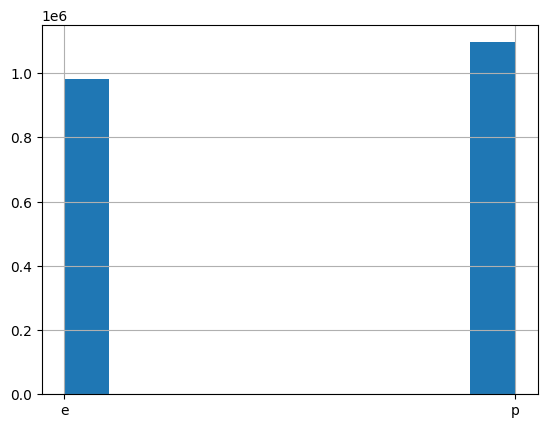

In [27]:
bp['class'].hist()

In [28]:
sample = pd.read_csv('/kaggle/input/playground-series-s4e8/test.csv')
binary_predictions_df = pd.concat([sample[['id']], bp['class']], axis=1)
binary_predictions_df.to_csv('binary_preds.csv', index = None)